# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

In [2]:
import os
import math

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn import set_config; set_config(display='diagram')

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

In [6]:
from collections import Counter

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [7]:
!pwd

/Users/Charlotte/code/charlottesuaud/data-certification-exam/machine_learning


### Loading data

In [8]:
path = os.path.join("data", "tv_movies_popularity.csv")

data = pd.read_csv(path)

print("\nData's shape :", data.shape, "\n")

data.head(3)


Data's shape : (6864, 17) 



,original_title,title,popularity,release_date,duration_min,description,budget,revenue,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,12314651.0,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,95149435.0,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,13092000.0,en,Released,97,145,0,Drama,United States of America,0,True


### Removing duplicates

In [9]:
len1 = len(data) # Check number of rows before removing duplicates

data = data.drop_duplicates() # Remove duplicates

len2 = len(data) # Check new number of rows

print("\nData's shape :", data.shape)
print("Number of duplicates: ", len1 - len2)


Data's shape : (6464, 17)
Number of duplicates:  400


### Missing values

In [10]:
missing_values = pd.DataFrame([
    data.isnull().sum(), 
    data.isnull().sum()/len(data)
], index=["null_count", "null_share"]).T.sort_values(by="null_share", ascending=False)

missing_values = missing_values[missing_values["null_count"] != 0]

missing_values

,null_count,null_share
revenue,3847.0,0.595142
title,1.0,0.000155


In [11]:
# Drop revenue column
data.drop(columns='revenue', inplace=True)

print("\nData's shape :", data.shape, "\n")

data.head(3)


Data's shape : (6464, 16) 



,original_title,title,popularity,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,en,Released,97,145,0,Drama,United States of America,0,True


In [12]:
# Check missing values again

missing_values = pd.DataFrame([
    data.isnull().sum(), 
    data.isnull().sum()/len(data)
], index=["null_count", "null_share"]).T.sort_values(by="null_share", ascending=False)

missing_values = missing_values[missing_values["null_count"] != 0]

missing_values

,null_count,null_share
title,1.0,0.000155


In [13]:
# Remove the row with missing title value
data.dropna(inplace=True)

print("\nData's shape :", data.shape, "\n")

data.head(3)


Data's shape : (6463, 16) 



,original_title,title,popularity,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,en,Released,97,145,0,Drama,United States of America,0,True


### 🧪 Run the following cell to save your results

In [14]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

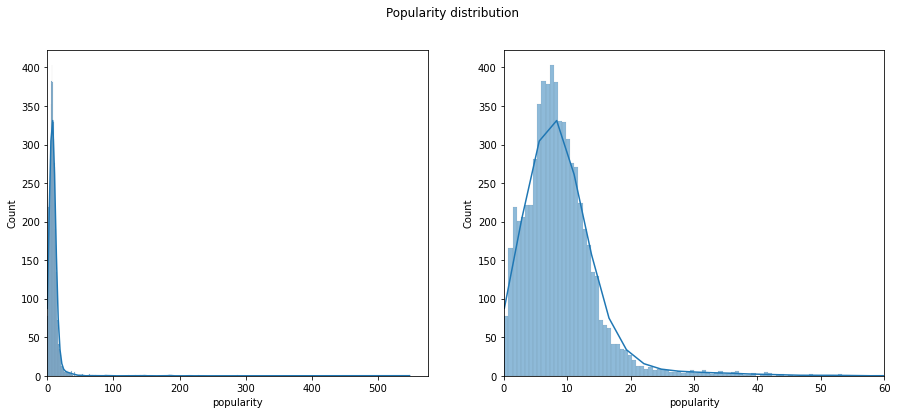

In [15]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.histplot(data=data, x="popularity", kde=True)
plt.xlim(left=0)

plt.subplot(1,2,2)
sns.histplot(data=data, x="popularity", kde=True)
plt.xlim(left=0)
plt.xlim(right=60)

plt.suptitle("Popularity distribution");

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

In [16]:
# 0. it's a regression problem !

# 1. "be better when greater" => the metric should be maximized to optimize the model
# ex. MSE or MAE are minimized to optimize models, we should consider neg-MSE or neg-MAE

# 2. Penalize more small errors than outliers 
# ex. MSE penalizes more outliers than MAE, but we consider neg metrics, then neg-MSE penalizes less outliers than neg-MAE

# => neg_mean_squared_error

In [17]:
scoring = "neg_mean_squared_error"

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [18]:
X = data.drop(columns=["popularity"])

print("\nX's shape :", X.shape)
print("X's type :", type(X), "\n")

X.head(3)


X's shape : (6463, 15)
X's type : <class 'pandas.core.frame.DataFrame'> 



,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,en,Released,97,145,0,Drama,United States of America,0,True


In [19]:
y = data["popularity"]

print("\ny's shape :", y.shape)
print("y's type :", type(y), "\n")

pd.DataFrame(y.head(3))


y's shape : (6463,)
y's type : <class 'pandas.core.series.Series'> 



,popularity
0,6.575393
1,8.248895
2,64.299990


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print("\nX_train's shape :", X_train.shape)


X_train's shape : (5170, 15)


### Basic pipeline

📝 **Check unique values per features**

In [21]:
X.dtypes

original_title                object
title                         object
release_date                  object
duration_min                 float64
description                   object
budget                         int64
original_language             object
status                        object
number_of_awards_won           int64
number_of_nominations          int64
has_collection                 int64
all_genres                    object
top_countries                 object
number_of_top_productions      int64
available_in_english            bool
dtype: object

In [22]:
# numeric columns : 
numerical = list(X.select_dtypes(['number']).columns)
print(f"\nNumerical features ({len(numerical)}) :\n", numerical)

# categorical & boolean columns : 
categorical = list(X.select_dtypes(['object', 'bool']).columns)
print(f"\nCategorical & boolean features ({len(categorical)}) :\n", categorical, "\n")


Numerical features (6) :
 ['duration_min', 'budget', 'number_of_awards_won', 'number_of_nominations', 'has_collection', 'number_of_top_productions']

Categorical & boolean features (9) :
 ['original_title', 'title', 'release_date', 'description', 'original_language', 'status', 'all_genres', 'top_countries', 'available_in_english'] 



In [23]:
# Check number of unique values for numerical features

print("\n-> Number of unique values for numerical features :")
for col in numerical:
    print(f"{col} : {X[col].nunique()}")

# Check number of unique values for categorical features

print("\n-> Number of unique values for categorical & boolean features :")
for col in categorical:
    print(f"{col} : {X[col].nunique()}")
    
# Check unique values for status, available_in_english and has_collection

print("\n-> Unique values for status, availables_in_english & has_collection :")
for col in ["status", "available_in_english", "has_collection"]:
    print(f"{col} : {X[col].unique()}")


-> Number of unique values for numerical features :
duration_min : 152
budget : 636
number_of_awards_won : 124
number_of_nominations : 180
has_collection : 2
number_of_top_productions : 5

-> Number of unique values for categorical & boolean features :
original_title : 6350
title : 6337
release_date : 4320
description : 6449
original_language : 42
status : 3
all_genres : 745
top_countries : 320
available_in_english : 2

-> Unique values for status, availables_in_english & has_collection :
status : ['Released' 'Rumored' 'Post Production']
available_in_english : [ True False]
has_collection : [1 0]


In this baseline, let's forget about the columns below that are difficult to process

In [24]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [25]:
numerical.remove("has_collection")

In [26]:
categorical = [cat for cat in categorical if cat not in text and cat not in dates]
categorical.append("has_collection")

In [27]:
print(f"numerical ({len(numerical)}) :", numerical)
print(f"categorical ({len(categorical)}) :", categorical)
print(f"text ({len(text)}) :", text)
print(f"dates ({len(dates)}) :", dates)

numerical (5) : ['duration_min', 'budget', 'number_of_awards_won', 'number_of_nominations', 'number_of_top_productions']
categorical (6) : ['original_language', 'status', 'all_genres', 'top_countries', 'available_in_english', 'has_collection']
text (3) : ['description', 'original_title', 'title']
dates (1) : ['release_date']


### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

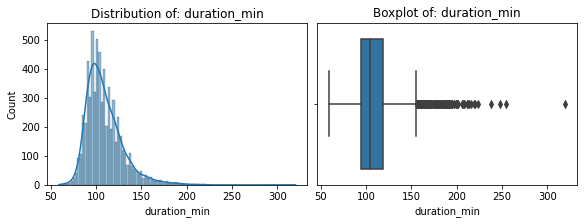

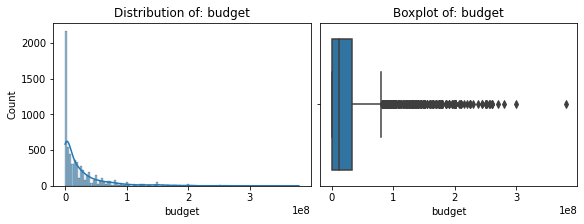

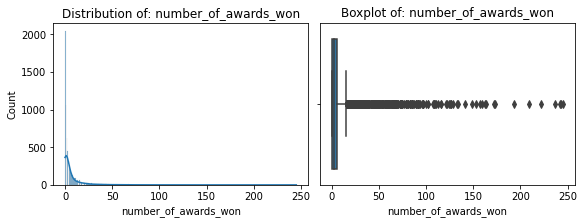

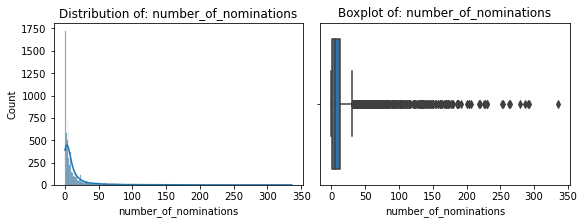

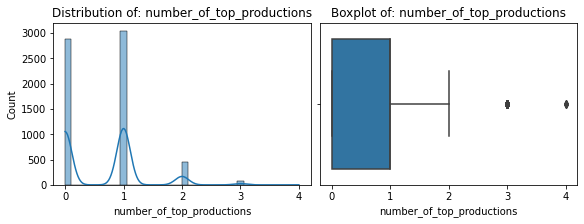

In [28]:
# Checking numercial features distribution before scaling

for col in numerical:
    plt.figure(figsize=(8,3), constrained_layout=True)
    plt.subplot(1, 2, 1)
    plt.title(f"Distribution of: {col}")
    sns.histplot(data=X[col], kde=True)
    plt.subplot(1, 2, 2)
    plt.title(f"Boxplot of: {col}")
    sns.boxplot(X[col])

In [29]:
num_transformer = Pipeline([('scaler', StandardScaler())])

cat_transformer = OneHotEncoder(handle_unknown='ignore')

basic_preprocessing = ColumnTransformer([
    ('num_transformer', num_transformer, numerical),
    ('cat_transformer', cat_transformer, categorical)],
    remainder='drop')

basic_preprocessing

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['duration_min', 'budget',
                                  'number_of_awards_won',
                                  'number_of_nominations',
                                  'number_of_top_productions']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['original_language', 'status', 'all_genres',
                                  'top_countries', 'available_in_english',
                                  'has_collection'])])

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [30]:
X_basic_preprocessing = basic_preprocessing.fit_transform(X_train)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

In [31]:
X_basic_preprocessing.shape

(5170, 999)

In [32]:
sum([X_train[col].nunique() for col in categorical]) + len(numerical)

999

In [33]:
sum([X[col].nunique() for col in categorical]) + len(numerical)

1119

In [34]:
# 1010 columns is exactly the number of columns we have to obtain when one-hot-encoding categorical features,
# and keeping numerical features in X_train
# NB. : if we had preprocessed the whole X, we would have obtained 1119 features, because some values might for 
# categorical features are only in X_test and not in X_test (handled with handle_unknown='ignore')

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [35]:
basic_pipeline = Pipeline([
    ('basic_preprocessing', basic_preprocessing),
    ('linear_regression', Lasso())
])

basic_pipeline

Pipeline(steps=[('basic_preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status', 'all_genres',
                                                   'top_countries',
                                                   'available_in_english',
                                                   'has_collection'])])),
                ('linear_regression', Lasso())])

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [36]:
basic_scores = cross_val_score(basic_pipeline, X_train, y_train, cv=5, scoring=scoring)
basic_scores.mean()

-76.62155830393648

### 🧪 Save your results

Run the following cell to save your results

In [37]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [38]:
class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        X_dt = X.copy()
        X_dt["release_date"] = pd.to_datetime(X_dt["release_date"])
        X_dt["month"] = X_dt["release_date"].dt.month
        X_dt["year"] = X_dt["release_date"].dt.year
        X_dt.drop(columns=["release_date"], inplace=True)
        
        return X_dt

In [39]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [40]:
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        self.max_year = X["year"].max()
        self.min_year = X["year"].min()
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        X_new = X.copy()
        X_new["month_cos"] = np.cos(2 * math.pi / 12 * X_new[['month']])
        X_new["month_sin"] = np.sin(2 * math.pi / 12 * X_new[['month']])
        X_new["year"] = (X_new["year"] - self.min_year) / self.max_year
        X_new.drop(columns=["month"], inplace=True)

        return X_new

In [41]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,year,month_cos,month_sin
0,0.046604,5.000000e-01,0.866025
1,0.041150,-5.000000e-01,-0.866025
2,0.046108,5.000000e-01,-0.866025
3,0.045117,6.123234e-17,1.000000
4,0.045117,-5.000000e-01,-0.866025


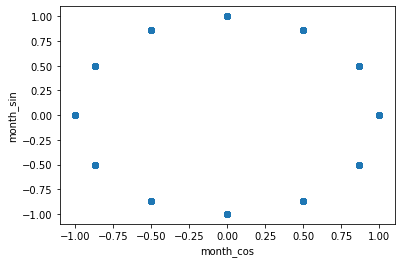

In [42]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [43]:
time_pipeline = Pipeline([
    ('time_features_extractor', TimeFeaturesExtractor()),
    ('cyclical_encoder', CyclicalEncoder())
])

time_pipeline

Pipeline(steps=[('time_features_extractor', TimeFeaturesExtractor()),
                ('cyclical_encoder', CyclicalEncoder())])

In [44]:
basic_preprocessing = ColumnTransformer([
    ('num_transformer', num_transformer, numerical),
    ('cat_transformer', cat_transformer, categorical),
    ('time_pipeline', time_pipeline, dates)],
    remainder='drop')

basic_preprocessing

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['duration_min', 'budget',
                                  'number_of_awards_won',
                                  'number_of_nominations',
                                  'number_of_top_productions']),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['original_language', 'status', 'all_genres',
                                  'top_countries', 'available_in_english',
                                  'has_collection']),
                                ('time_pipeline',
                                 Pipeline(steps=[('time_features_extractor',
                                                  TimeFeaturesExtractor()),
                                                 ('cyclical_encoder',
                                                  CyclicalEncoder())]),
                                 ['release_date'])])

In [45]:
basic_pipeline = Pipeline([
    ('basic_preprocessing', basic_preprocessing),
    ('linear_regression', Lasso())
])

basic_pipeline

Pipeline(steps=[('basic_preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status', 'all_genres',
                                                   'top_countries',
                                                   'available_in_english',
                                                   'has_collection']),
                                                 ('time_pipeline',
                                                  Pipeline(steps=[('time_features_extractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical_encoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date'])])),
                ('linear_regression', Lasso())])

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [46]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [47]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [48]:
class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [49]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [50]:
categorical.remove("all_genres")
categorical.remove("top_countries")

In [51]:
print(f"numerical ({len(numerical)}) :", numerical)
print(f"categorical ({len(categorical)}) :", categorical)
print(f"text ({len(text)}) :", text)
print(f"dates ({len(dates)}) :", dates)

numerical (5) : ['duration_min', 'budget', 'number_of_awards_won', 'number_of_nominations', 'number_of_top_productions']
categorical (4) : ['original_language', 'status', 'available_in_english', 'has_collection']
text (3) : ['description', 'original_title', 'title']
dates (1) : ['release_date']


In [52]:
final_preprocessing = ColumnTransformer([
    ('num_transformer', num_transformer, numerical),
    ('cat_transformer', cat_transformer, categorical),
    ('time_pipeline', time_pipeline, dates),
    ('genre_country_encoder', CustomGenreAndCountryEncoder(), ['all_genres', 'top_countries'])],
    remainder='drop')

final_pipeline = Pipeline([
    ('final_processing', final_preprocessing),
    ('linear_regression', Lasso())
])

final_pipeline

Pipeline(steps=[('final_processing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status',
                                                   'available_in_english',
                                                   'has_collection']),
                                                 ('time_pipeline',
                                                  Pipeline(steps=[('time_features_extractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical_encoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date']),
                                                 ('genre_country_encoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('linear_regression', Lasso())])

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

In [53]:
%%time
final_scores = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring=scoring)
final_scores.mean()

CPU times: user 1.38 s, sys: 182 ms, total: 1.56 s
Wall time: 862 ms


-76.6215583039365

### 🧪 Save your result

Run the following cell to save your results.

In [54]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [55]:
final_pipeline = Pipeline([
    ('final_processing', final_preprocessing),
    ('random_forest', RandomForestRegressor(n_jobs=-1))
])

final_pipeline

Pipeline(steps=[('final_processing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status',
                                                   'available_in_english',
                                                   'has_collection']),
                                                 ('time_pipeline',
                                                  Pipeline(steps=[('time_features_extractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical_encoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date']),
                                                 ('genre_country_encoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('random_forest', RandomForestRegressor(n_jobs=-1))])

In [56]:
%%time
final_scores = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring=scoring)
final_scores.mean()

CPU times: user 2.21 s, sys: 838 ms, total: 3.04 s
Wall time: 13.3 s


-76.75450191062991

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [57]:
final_pipeline.get_params()

{'memory': None,
 'steps': [('final_processing',
   ColumnTransformer(transformers=[('num_transformer',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['duration_min', 'budget',
                                     'number_of_awards_won',
                                     'number_of_nominations',
                                     'number_of_top_productions']),
                                   ('cat_transformer',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['original_language', 'status',
                                     'available_in_english', 'has_collection']),
                                   ('time_pipeline',
                                    Pipeline(steps=[('time_features_extractor',
                                                     TimeFeaturesExtractor()),
                                                    ('cyclical_enc

In [58]:
param_grid = {
    'random_forest__max_depth': [50, 100],
    'random_forest__min_samples_leaf': [2, 5],
    'random_forest__n_estimators': [50, 100]
}

In [59]:
search = GridSearchCV(final_pipeline, param_grid, n_jobs=-1, cv=5)

In [60]:
%%time
search.fit(X_train, y_train)

CPU times: user 4.28 s, sys: 78.9 ms, total: 4.36 s
Wall time: 32.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('final_processing',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['duration_min',
                                                                          'budget',
                                                                          'number_of_awards_won',
                                                                          'number_of_nominations',
                                                                          'number_of_top_productions']),
                                                                        ('cat_transformer',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['original_language',
                                                                          'status'...
                                                                                          TimeFeaturesExtractor()),
                                                                                         ('cyclical_encoder',
                                                                                          CyclicalEncoder())]),
                                                                         ['release_date']),
                                                                        ('genre_country_encoder',
                                                                         CustomGenreAndCountryEncoder(),
                                                                         ['all_genres',
                                                                          'top_countries'])])),
                                       ('random_forest',
                                        RandomForestRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [50, 100],
                         'random_forest__min_samples_leaf': [2, 5],
                         'random_forest__n_estimators': [50, 100]})

In [61]:
best_scores = search.cv_results_['mean_test_score']

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [62]:
best_pipeline = search.best_estimator_
best_pipeline

Pipeline(steps=[('final_processing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status',
                                                   'available_in_english',
                                                   'has_collection']),
                                                 ('time_pipeline',
                                                  Pipeline(steps=[('time_features_extractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical_encoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date']),
                                                 ('genre_country_encoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=5,
                                       n_jobs=-1))])

In [63]:
best_pipeline.fit(X, y)

Pipeline(steps=[('final_processing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'number_of_nominations',
                                                   'number_of_top_productions']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status',
                                                   'available_in_english',
                                                   'has_collection']),
                                                 ('time_pipeline',
                                                  Pipeline(steps=[('time_features_extractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclical_encoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date']),
                                                 ('genre_country_encoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=5,
                                       n_jobs=-1))])

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [64]:
X_to_predict = pd.DataFrame.from_dict(dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
))

X_to_predict

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,La Casa de Papel,Money Heist,2017-05-02,50.0,An unusual group of robbers attempt to carry o...,3000000.0,es,Released,2,5,1,"Action, Crime, Mystery","Spain, France, United States of America",1,True


In [65]:
popularity = best_pipeline.predict(X_to_predict)[0]
popularity

13.79392061292844

### 🧪 Save your results

Run the following cell to save your results.

In [66]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**